**Objective:**

We will try to gain more insight about the global household electric power consumption by using time series forecasting.

**Dataset Information:**
It is a real-world power usage data from a single household in Sceaux (7km of Paris, France), recorded at 1-minute intervals, between December 2006 and November 2010 (47month). Please refer more detail about the dataset in
<a href='https://vast-part-d09.notion.site/Data-Pipeline-Implementation-1bc7e6ac7d0780e19be3fcf311b4a4af?pvs=73'>Data Pipeline Implementation | Notion</a>

- The dataset consisted of **9 features**: 
    - **Date**: Date in format dd/mm/yyyy
    - **Time**: time in format hh:mm:ss
    - **Global_active_power**: household global minute-averaged active power (in kilowatt)
    - **Global_reactive_power**: household global minute-averaged reactive power (in kilowatt)
    - **Voltage**: household global minute-averaged reactive power (in kilowatt)
    - **Global_intensity**: household global minute-averaged current intensity (in ampere)
    - **Sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
    - **Sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
    - **Sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.
- Instances: 2075259

**For initial start we will conduct 6 primary steps:**

Data pre-processing -> Exploratory Data Analysis (EDA) -> Data preparation -> Building and Training LSTM model (train set) -> Model Evaluation -> Visualization

1. Data pre-processing: handle missing value, converting the data into a stationary time series
2. EDA: understanding pattern and trend
3. Data preparation: prepare and split data (train, test set) and transform data for LSTM
4. Building mode: we are using LSTM and SARIMA (Seasonal Autoregressive Integrated Moving Average) for comparison
5. Model evaluation: perform metrics on both sets
6. Visualization



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from time import time
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

warnings.filterwarnings('ignore')

import matplotlib.ticker as tkr

%matplotlib inline

##### Step 1: Data Pre-processing

In [3]:
df = pd.read_csv('D:/ai_team/self-dr-vpp/data/raw/household_power_consumption.txt', 
                   delimiter=';',
                   na_values='?',
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True,
                   low_memory=False)

In [4]:
print(' Number of rows and columns:', df.shape)
df.head(5)

 Number of rows and columns: (2075259, 8)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
1,2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2,2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000
3,2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000,0.0000,1.0000,17.0000
4,2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000


In [5]:
# convert all data columns name to lowercase and remove spaces
df.columns = [col.lower() for col in df.columns]

In [6]:
print('Data information:', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   global_active_power    float64       
 2   global_reactive_power  float64       
 3   voltage                float64       
 4   global_intensity       float64       
 5   sub_metering_1         float64       
 6   sub_metering_2         float64       
 7   sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
Data information: None


In [7]:
print('Data description:', df.describe())

Data description:                             datetime  global_active_power  \
count                        2075259         2049280.0000   
mean   2008-12-06 07:12:59.999994112               1.0916   
min              2006-12-16 17:24:00               0.0760   
25%              2007-12-12 00:18:30               0.3080   
50%              2008-12-06 07:13:00               0.6020   
75%              2009-12-01 14:07:30               1.5280   
max              2010-11-26 21:02:00              11.1220   
std                              NaN               1.0573   

       global_reactive_power      voltage  global_intensity  sub_metering_1  \
count           2049280.0000 2049280.0000      2049280.0000    2049280.0000   
mean                  0.1237     240.8399            4.6278          1.1219   
min                   0.0000     223.2000            0.2000          0.0000   
25%                   0.0480     238.9900            1.4000          0.0000   
50%                   0.1000     241.

In [8]:
df.tail(5)

,datetime,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2075254,2010-11-26 20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,2010-11-26 20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,2010-11-26 21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,2010-11-26 21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000
2075258,2010-11-26 21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000


Feature Engineering

In [9]:
# Convert the Global_active_power to numeric and remove missing values
df['global_active_power'] = pd.to_numeric(df['global_active_power'], errors='coerce')
df = df.dropna(subset=['global_active_power'])

In [10]:
df['datetime'] = pd.to_datetime(df['datetime']) 

In [11]:
# create new columns for year, quarter, month, day, hour and minute, we are using dt(change over time) accessor instead of 
    # lamda function for better datetime extraction
df['year'] = df['datetime'].apply(lambda x: x.year)
df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.day)

In [12]:
# keep only the columns such as datetime, global_active_power, year, quarter, month, day, hour and minute
df = df.loc[:,['datetime','global_active_power', 'year','quarter','month','day']]

In [13]:
# sort data by datetime
df.sort_values('datetime', inplace=True, ascending=True)

In [14]:
# reset index
df = df.reset_index(drop=True)

In [15]:
# column'weekday' if the day is a weekday (1) or weekend (0)
df['weekday'] = df['datetime'].apply(lambda x: x.weekday() < 5).astype(int)

In [16]:
print('Number of rows and columns:', df.shape)
print('Minimum datetime:', df.datetime.min())
print('Maximum datetime:', df.datetime.max())

df.tail(5)

Number of rows and columns: (2049280, 7)
Minimum datetime: 2006-12-16 17:24:00
Maximum datetime: 2010-11-26 21:02:00


,datetime,global_active_power,year,quarter,month,day,weekday
2049275,2010-11-26 20:58:00,0.9460,2010,4,11,26,1
2049276,2010-11-26 20:59:00,0.9440,2010,4,11,26,1
2049277,2010-11-26 21:00:00,0.9380,2010,4,11,26,1
2049278,2010-11-26 21:01:00,0.9340,2010,4,11,26,1
2049279,2010-11-26 21:02:00,0.9320,2010,4,11,26,1


Normality testing target on global_active_power.
- We need to check if the data is normally distributed 
- The determination is base on D'Agostino's K^2 Test
- We will initialized a p-value for our hypothesis

Hypothesis (H0,H1): 
```python
alpha = 0.05

if p_value <= alpha, we will reject H0: global_active_power is not normally distributed 
else:
p_value > alpha, we will to reject H0: global_active_power appears normally distributed
```

In [22]:
import scipy.stats as stats

stat, p_value = stats.normaltest(df['global_active_power'])  # D'Agostino and Pearson's Test
print('Statistics=%.3f, p=%.3f' % (stat, p_value))

if p_value < 0.05:
    print('Reject H0: The distribution of global active power is not normal')
else:
    print('Fail to reject H0: The distribution of global active power is normal')

Statistics=724881.795, p=0.000
Reject H0: The distribution of global active power is not normal


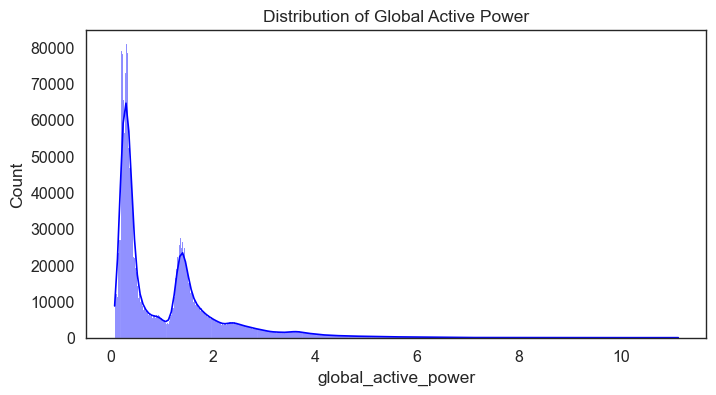

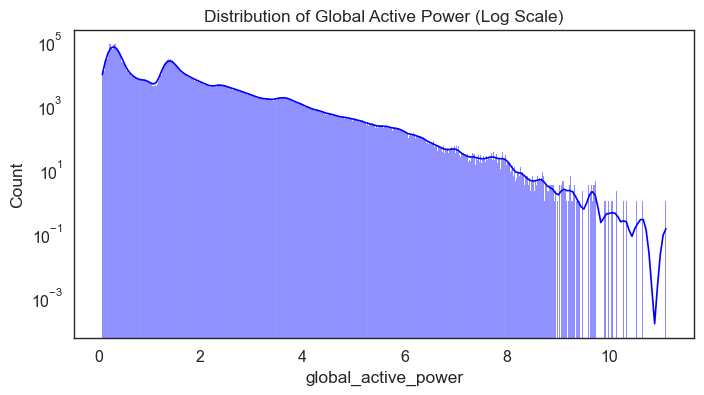

Text(0.5, 1.0, 'Histogram of Global Active Power')

In [25]:
# plot the distribution of global active power
plt.figure(figsize=(8,4))
sns.histplot(df['global_active_power'], kde=True, color='blue')
plt.title('Distribution of Global Active Power')
plt.show()

# plot the distribution of global active power on a log scale
plt.figure(figsize=(8,4))
sns.histplot(df['global_active_power'], kde=True, color='blue')
plt.yscale('log')
plt.title('Distribution of Global Active Power (Log Scale)')
plt.show() 

# histogram and Q-Q plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(df['global_active_power'], kde=True, color='blue')
plt.title('Histogram of Global Active Power')


In [26]:
# kurtosis of normal distribution (Fisher-Pearson coefficient of kurtosis)
kurtosis = stats.kurtosis(df['global_active_power'])
print('Kurtosis:', kurtosis)

# skewness of normal distribution
skewness = stats.skew(df['global_active_power'])
print('Skewness:', skewness)

Kurtosis: 4.218671866132123
Skewness: 1.7862320846320818


### Summary Insight of Kurtosis and Skewness

- **Kurtosis (4.22)**: The kurtosis value is greater than 3, indicating that the distribution of `global_active_power` has heavier tails compared to a normal distribution. This suggests the presence of outliers or extreme values in the data.

- **Skewness (1.79)**: The skewness value is positive, indicating that the distribution of `global_active_power` is right-skewed. This means that the data has a longer tail on the right side, with a concentration of values on the lower end.

So, we are looking for a symmetry skewness between -0.5 and 0.5 to be consider fairly symmetrical. However, if the skewness fall between -1 & -0.5 or 0.5 & 1, the data is considered moderately skew. In our case, the skewness shown greater than 1, which indicated a highly skewed data. Therefore, these insights suggest that the data is not normally distributed, as confirmed by the p-value from the normality test (`p_value = 0.0`), which leads to rejecting the null hypothesis of normality.

##### Step 2: Exploratory Data Analysis (EDA)

##### Step 3: Data Preparation for Modeling

##### Step 4: Building and Training the LSTM Model

##### Step 5: Model Evaluation

##### Step 6: Visualizations

In [18]:


# Read the dataset 
# Note: The file uses ';' as delimiter and missing values are represented by '?'
df = pd.read_csv(r"data\raw\household_power_consumption.txt", 
                 sep=';', 
                 parse_dates=[[0, 1]], 
                 infer_datetime_format=True, 
                 low_memory=False,
                 na_values='?')
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)
df.set_index('Datetime', inplace=True)

# Convert the Global_active_power column to numeric and drop missing values
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df.dropna(subset=['Global_active_power'], inplace=True)

# To make the series stationary, we apply difference (you may check stationarity with tests if needed)
df['GAP_diff'] = df['Global_active_power'].diff().dropna()
df.dropna(inplace=True)

# Step 2: 
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power')
plt.title("Household Global Active Power Consumption")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.show()

# Step 3: 
# Use the differenced series for modeling
series = df['GAP_diff'].values.reshape(-1, 1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series)

# Function to create sequences for LSTM [look_back time steps]
def create_dataset(data, look_back=24):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 24  # e.g., using the past 24 observations to predict the next
X, y = create_dataset(series_scaled, look_back)

# Reshape input to be [samples, time steps, features] required by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Building and Training the LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, 
                    validation_data=(X_test, y_test), verbose=1)

# Step 5: 
# Predict on training and testing sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
train_predict_inv = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict_inv = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate errors
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)
print("Testing MAE:", test_mae)
print("Testing RMSE:", test_rmse)

# Step 6: Visualizations
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Plot actual vs predicted for testing data
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual GAP_diff')
plt.plot(test_predict_inv, label='Predicted GAP_diff')
plt.title("Actual vs Predicted Global Active Power Differential")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power Difference")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data\\raw\\household_power_consumption.txt'